```
Mounted at /content/drive   
Checking paths...  
Metadata file exists: True  
Audio directory exists: True  
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth  
100%|██████████| 83.3M/83.3M [00:00<00:00, 135MB/s]  
Model device: cpu  
Finding optimal learning rate...

```

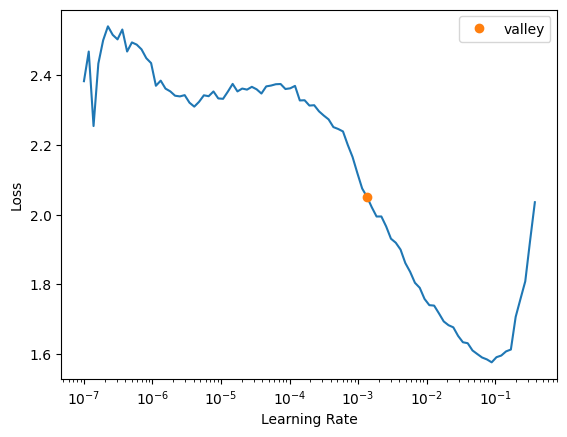

In [1]:
from fastai.vision.all import *
from fastai.callback.all import *
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
# Path setup
DATASET_PATH = "/content/drive/MyDrive/urbansound8k"
AUDIO_DIR = os.path.join(DATASET_PATH, "audio")
METADATA_PATH = os.path.join(AUDIO_DIR, "filtered_UrbanSound8K.csv")

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("Running on CPU")

# Audio preprocessing
def load_and_preprocess_audio(file_path, sr=22050, duration=3):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)))
        mel_spect = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=128, fmax=8000
        )
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        return mel_spect_db
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Data preparation
def prepare_data_for_fastai(metadata_path, audio_dir):
    metadata = pd.read_csv(metadata_path)
    df = pd.DataFrame({
        'fname': [os.path.join(audio_dir, f'fold{row.fold}', row.slice_file_name)
                 for _, row in metadata.iterrows()],
        'label': metadata['classID'],
        'fold': metadata['fold']
    })
    return df.reset_index(drop=True)

# FastAI data helpers
def get_x(row):
    mel_spect = load_and_preprocess_audio(row.fname)
    if mel_spect is None or mel_spect.size == 0:
        print(f"Failed to process {row.fname}")
        return np.zeros((128, 128, 3), dtype=np.uint8)
    mel_spect = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
    mel_spect_3d = np.repeat(mel_spect[..., None], 3, axis=-1)
    mel_spect_uint8 = (mel_spect_3d * 255).astype(np.uint8)
    return mel_spect_uint8

def get_y(row): return row.label

# Single Train-Val Split
def train_single_split(df, val_pct=0.2):
    db = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=get_x,
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=val_pct, seed=42),
        batch_tfms=[*aug_transforms(size=(128, 128)), Normalize]
    )

    dls = db.dataloaders(df, bs=32)
    learn = vision_learner(dls, resnet34, metrics=[accuracy],
                          cbs=[ShowGraphCallback()])

    # Confirm model is on GPU
    print(f"Model device: {next(learn.model.parameters()).device}")

    print("Finding optimal learning rate...")
    lr_suggestion = learn.lr_find(start_lr=1e-7, end_lr=1.0, num_it=100, show_plot=True)  # stop_div=False ensures it completes
    suggested_lr = lr_suggestion.valley
    return suggested_lr, learn


# Execute
df = prepare_data_for_fastai(METADATA_PATH, AUDIO_DIR)
print("Checking paths...")
print(f"Metadata file exists: {os.path.exists(METADATA_PATH)}")
print(f"Audio directory exists: {os.path.exists(AUDIO_DIR)}")

#Split original DataFrame into train_val and test
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'])

# Run single split
suggested_lr, learn= train_single_split(train_val_df, val_pct=0.2)

Suggested learning rate: `0.0013489628909155726`

 Training with frozen weights

epoch,train_loss,valid_loss,accuracy,time
0,1.329659,0.439768,0.836207,06:14
1,0.754507,0.353492,0.890086,04:56
2,0.529576,0.233084,0.924569,04:51
3,0.414129,0.219047,0.924569,04:54
4,0.330251,0.216343,0.926724,05:00


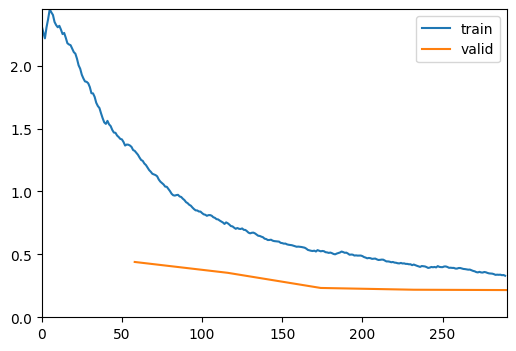

 Fine-tuning

epoch,train_loss,valid_loss,accuracy,time
0,0.298988,0.277918,0.918103,06:45
1,0.356176,0.312935,0.920259,06:39
2,0.293618,0.119499,0.974138,06:47
3,0.241107,0.210682,0.956897,06:45
4,0.175739,0.070079,0.969828,06:44
5,0.137278,0.038197,0.987069,06:45
6,0.103968,0.060720,0.976293,06:40
7,0.083615,0.047553,0.984914,06:40
8,0.054832,0.028915,0.991379,06:36
9,0.040301,0.030338,0.989224,06:42


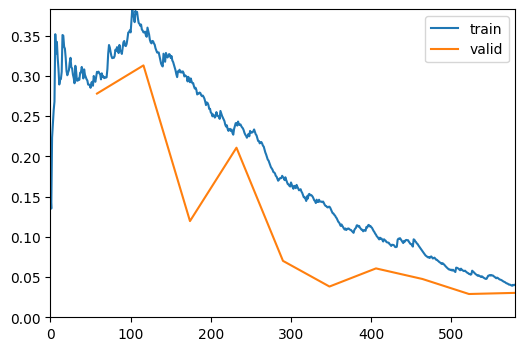

Validation accuracy: `0.9892`

In [7]:
print(f"Suggested learning rate: {suggested_lr}")

print("Training with frozen weights...")
learn.fit_one_cycle(5, suggested_lr)

print("Fine-tuning...")
learn.unfreeze()
learn.fit_one_cycle(10, slice(suggested_lr/10, suggested_lr))

val_acc = learn.validate()[1]
print(f"Validation accuracy: {val_acc:.4f}")


In [8]:
# Properly create test DataLoader with labels
test_dl = learn.dls.test_dl(test_df, with_labels=True)

# Evaluate on test set
test_loss, test_acc = learn.validate(dl=test_dl)
print(f"Test set accuracy: {test_acc:.4f}")

Test set accuracy: 0.9902


In [9]:

# Save the trained model
print("Saving the model...")
model_path = "audio_classifier.pkl"
learn.export(model_path)
print(f"Model saved to {model_path}")

# Function to make predictions on new audio
def predict_audio(audio_path, learn):
    # Load and preprocess the audio
    mel_spect = load_and_preprocess_audio(audio_path)
    if mel_spect is None:
        return None

    # Convert to image format
    mel_spect = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
    mel_spect_3d = np.repeat(mel_spect[..., None], 3, axis=-1)
    mel_spect_uint8 = (mel_spect_3d * 255).astype(np.uint8)

    # Make prediction
    pred_class,pred_idx,probs = learn.predict(mel_spect_uint8)
    return {
        'predicted_class': str(pred_class),
        'confidence': float(probs[pred_idx])
    }

Saving the model...
Model saved to audio_classifier.pkl
